# Intro
The task is to classify military aircrafts into twenty types, i.e., labels using ConvNets.

In [1]:
# Required packages
import pandas as pd
import numpy as np
import os
import xml.etree.ElementTree as ET
from colorama import Fore, Back, Style
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image, ImageDraw
import itertools
from sklearn.preprocessing import OneHotEncoder
import keras_tuner as kt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load and Read the data

In [2]:
# Read annotations from an xml file
def read_annotations(xml_path):
    '''
    This function reads the ‘xml’ files containing the annotations
    Input: path to the xml file
    Output: a list containing the label and the annotations
    '''
    # Parse the XML file
    tree = ET.parse(xml_path)
    
    # Get the root element of the XML tree
    root = tree.getroot()
    
    # Initialize an empty list to store the annotations
    annotations = []
    
    # Loop through <object> elements in the XML
    for obj in root.findall('object'):
        
        # Extract the label from the <name> element
        name = obj.find('name').text
        
        # Extract the bounding box coordinates from the <bndbox> element
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        annotations.append((name, (xmin, ymin, xmax, ymax)))
        
    # Return the list of annotations
    return annotations

In [3]:
# This function reads the images from the files 
def read_data(file_names):
    '''
    This function reads the images from the files.
    Returns a tuple:
    data: The data with images an corresponding annotations 
    dims: List of all dimensions encountered throughout the dataset
    '''
    # Initialize two empty lists 
    data = []
    dims = []
    
    # Loop over the file names extracted and read the images and annotations
    for file_name in file_names:
        
        # Get the paths to the files
        img_path = os.path.join(data_dir, 'JPEGImages', 
                                file_name + '.jpg')
        xml_path = os.path.join(data_dir, 'Annotations', 
                                'Horizontal Bounding Boxes', 
                                file_name + '.xml')
        
        # Read the image
        img = Image.open(img_path)
        
        # Exclude 4-channel images
        if (np.array(img).shape[2]) != 3:
            continue
        
        # Extract annotations
        annotations = read_annotations(xml_path)

        # Get the dimensions of all objects and store it for later use
        for annot in annotations:
            width = abs(annot[1][0] - annot[1][2])
            height = abs(annot[1][1] - annot[1][3])
            dims.append(width)
            dims.append(height)

        data.append((img, annotations))
        
        
    return data, dims

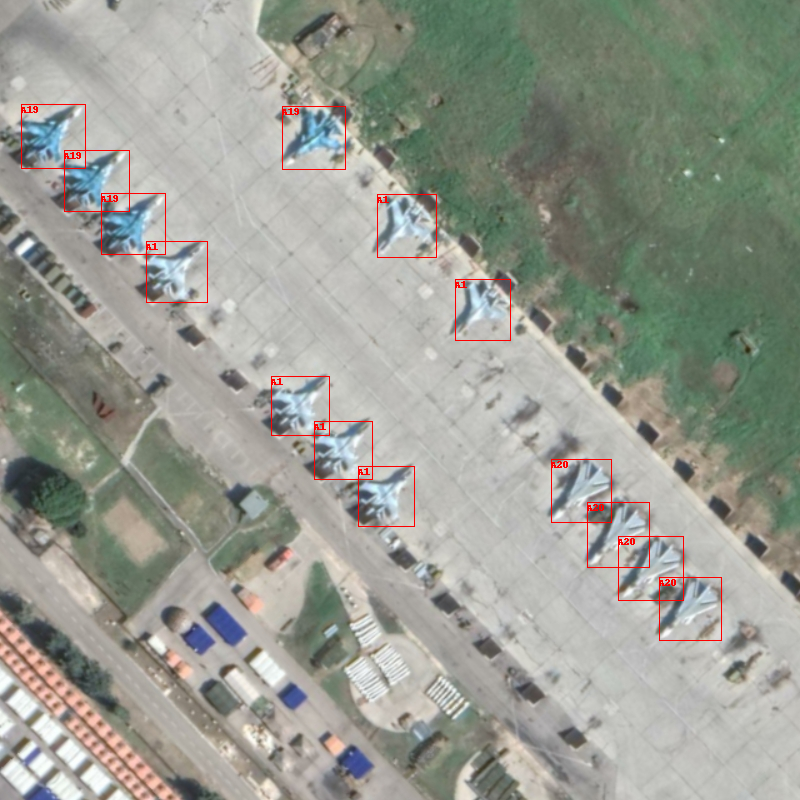

In [4]:
# Define the path to the data directory
data_dir = '/kaggle/input/military-aircraft-recognition-dataset'

# Read the train and test filenames from the ImageSets/Main folder
with open(os.path.join(data_dir, 'ImageSets/Main/train.txt'), 'r') as f:
    train_filenames = f.read().splitlines()
train_data, train_obj_dims = read_data(train_filenames)

'''
####################### TEST SET #######################
with open(os.path.join(data_dir, 'ImageSets/Main/test.txt'), 'r') as f:
    test_filenames = f.read().splitlines()
test_data, test_obj_dims = read_data(test_filenames)
'''


# Display an exmple
img = train_data[0][0]
draw = ImageDraw.Draw(img)
objects = train_data[0][1]
for obj in objects:
    draw.rectangle(obj[1], outline='red')
    draw.text((obj[1][0], obj[1][1]), obj[0], fill='red')
img

We need the images to be of the same size. Since we are going to extract objects from each image, they will not be of the same size as the annotations do not cover the same area, i.e., some form a smaller rectangle with dimensions (24, 24), and some bigger ones like (111, 140). Therefore, they need to be transformed in a way that they are of equal dimensions. Having said that, we also need to make sure the ratio of images don’t change. The easiest way to do so, is to create a squared empty image and paste the object onto the center of it, of which the function below takes care.

# Preprocessing

In [5]:
def pad_img(img):
    '''
    This function transforms an image to the desired size. 
    If squared, the image remains the same in ratio; 
    if rectnagular, it'll be padded evenly to become a squared one.
    '''
    # Get the dimensions the image
    old_size = img.size
    
    # Define the desired size to transform the image to
    desired_size = (64,64)
    
    # Calculate the maximum dimension of the original image
    max_dim = max(old_size)
    
    # Create a new image with the max_dim as the width and height
    padded = Image.new("RGB", (max_dim, max_dim))
    
    # Calculate the padding for the image to make it square
    x = (max_dim - old_size[0]) // 2
    y = (max_dim - old_size[1]) // 2
    
    # Paste the original image onto the padded image at the calculated position
    padded.paste(img, (x, y))
    
    # Resize the padded image to the desired size
    out_img = padded.resize(desired_size)
    
    # Return the transformed image
    return out_img

In [6]:
def extract_obj(img, annotations):
    '''
    This function extracts objects from an image based on provided annotations
    '''
    # Define lists to keep objects in an image and their labels
    objects = []
    labels = []
    
    # Loop through annotations, each of which contain a label and 
    # a bounding box denoted by 'b_box'
    for label, b_box in annotations:
        labels.append(label)
        roi = img.crop(b_box)
        
        # Add roi to the list
        objects.append(roi)
        
    
    # Convert labels to numpy array
    labels = np.array(labels)
    
    # Return objects as individual images as well as their labels
    return objects, labels

### Prepare X_train, y_train

In [7]:
def preprocessing(data):
    
    # Define two temporary lists to store objects and labels
    X_temp = []
    y_temp = []
    
    # Iterate over images and annotations to prepare X_train and y_train
    for img, annotations in data:

        # Extract the objects from current image
        objects, labels = extract_obj(img, annotations)

        # Pad objects
        padded = []
        for obj in objects:
            padded_img = pad_img(obj)
            padded.append(padded_img)

        # Add the objects to two temporary lists
        X_temp.append(padded)
        y_temp.append(labels)

    # Flatten the list of labels and convert to numpy array
    orig_labels = list(itertools.chain(*y_temp))
    orig_labels_np = np.array(orig_labels).reshape(-1, 1)
    
    # Encode the labels
    encoder = OneHotEncoder()
    y = encoder.fit_transform(orig_labels_np).toarray()

    n_channels = 3
    
    X_list = []
    
    # Normalize and create a list of image arrays
    for img in X_temp:
        for obj in img:
            X_list.append(np.array(obj)/255.0)
    
    # Convert the list of images to an array
    X = np.array(X_list)
            
    return X, y, orig_labels_np

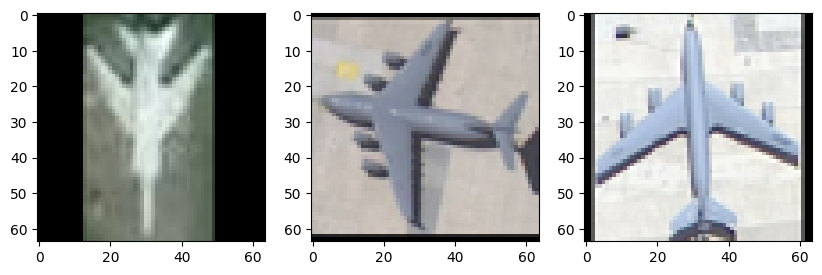

In [8]:
# Get features and labels
X, y, orig_labels = preprocessing(train_data)
n_labels = y.shape[1]

# Display some of the padded objects
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 3))
ax0.imshow(X[np.argmin(train_obj_dims)//2], cmap='gray')
ax1.imshow(X[30], cmap='gray')
ax2.imshow(X[np.argmax(train_obj_dims)//2], cmap='gray')

In [9]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

# Shape check
print(Back.RESET + Fore.YELLOW + f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(Back.RESET + Fore.YELLOW + f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (5234, 64, 64, 3)
y_train.shape: (5234, 20)
X_test.shape: (2578, 64, 64, 3)
y_test.shape: (2578, 20)


# CNN Hyper-parameter Tuning

There different parameters that can be tuned to improve the model:
1. Number of convolutional layers: more layers can potentially capture more complex features; however, too many convolutional layers can also lead to overfitting.
2. Number of filters: increasing this number can make the model learn more intricate patterns existing in the images; however, it increases computational cost.
3. Filter size: this parameter helps capture different levels of details and patterns. Increasing it might help exploit more details.
4. Pooling size: pooling is a technique of reducing spatial dimensions of an image; smaller pooling filter sizes retain more spatial information; the catch is it increases the computational cost.
3. Activation functions: the ability to learn and generalize is handled by activation functions. For example, if I change ReLU, which I used in the code above, to LeakyReLU or ELU, it might mitigate the “dying ReLU” problem.
4. Learning Rate: this is the step size taken to reach convergence during gradient descent optimization. If it’s too high, may cause unstable training. 
5. Batch size: batch size is the number of training samples processed before updating the model’s weights. Although larger batch sizes may result in faster training, they require more memory. Smaller batch sizes on the other hand, can essentially lead to better generalization but slower convergence.
6. Number of epochs: this is the number of times the model iterates over the entire training set. Too few epochs can result in underfitting, while too many of them may result in overfitting.
7. Regularization: the `dropout` seen in my code is one of the regularization techniques; L1/L2 regularization and batch normalization are other examples. These techniques can help prevent overfitting. 
8. Optimizer: the choice of optimizer affects the speed and quality of convergence. 

There are different approaches to determining **the most optimal hyper-parameters** for a CNN model:
1. Grid Search: in grid search, a grid of possible parameter values for each parameter to be tuned is defined. The grid search algorithm exhaustively evaluates all possible combinations of parameters and selects the one that results in the best performance.
2. Random Search: While grid search explores all combinations, random search involves sampling parameter values from predefined ranges randomly. It doesn’t guarantee the best results due to random sampling. 
3. Automated Hyper-parameter Tuning: we can use libraries such as Keras Tuner and employ their built-in functions that implement search techniques to handle the search process. Since automated, they can be quite efficient and find the most optimal configuration for the model.

I'll utilized the last approach for this particular task. 


In [10]:
# Define a model-building function
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                            input_shape=(64, 64, 3)))
    model.add(layers.AveragePooling2D((2, 2)))
    
    # Tune the number of convolutional layers
    for i in range(hp.Int('conv_layers', 1, 3)):
        model.add(layers.Conv2D(hp.Int(f'filters_{i}', 32, 128, step=32), 
                                (3, 3), activation='relu'))
        model.add(layers.AveragePooling2D((2, 2)))

    model.add(layers.Flatten())
    
    # Tune the number of units in the dense layer
    model.add(layers.Dense(hp.Int('units', 64, 256, step=32), 
                           activation='relu'))
    
    # Add a dropout layer
    model.add(layers.Dropout(hp.Float('dropout', 0.3, 0.6, step=0.1)))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    
    model.add(layers.Dense(n_labels, activation='softmax'))
    
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    
    return model

# Training and testing the model (on UNSEEN data)

In [11]:
# Create a KerasTuner Hyperband tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=100,
    directory='my_dir',
    project_name='my_project'
)

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=60, validation_data=(X_test, y_test))

Trial 254 Complete [00h 01m 59s]
val_accuracy: 0.9181535840034485

Best val_accuracy So Far: 0.927463173866272
Total elapsed time: 01h 03m 39s


In [12]:
# Print the best hyperparameters found
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps}")

# Build and train the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Best Hyperparameters: <keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7d1530117c70>
Epoch 1/100
164/164 [==============================] - 3s 9ms/step - loss: 2.2573 - accuracy: 0.3095 - val_loss: 1.6103 - val_accuracy: 0.5167
Epoch 2/100
164/164 [==============================] - 1s 6ms/step - loss: 1.3118 - accuracy: 0.5873 - val_loss: 0.9664 - val_accuracy: 0.6936
Epoch 3/100
164/164 [==============================] - 1s 6ms/step - loss: 0.9288 - accuracy: 0.7063 - val_loss: 0.7199 - val_accuracy: 0.7556
Epoch 4/100
164/164 [==============================] - 1s 6ms/step - loss: 0.6893 - accuracy: 0.7776 - val_loss: 0.6719 - val_accuracy: 0.7836
Epoch 5/100
164/164 [==============================] - 1s 7ms/step - loss: 0.5398 - accuracy: 0.8208 - val_loss: 0.5504 - val_accuracy: 0.8328
Epoch 6/100
164/164 [==============================] - 1s 7ms/step - loss: 0.4205 - accuracy: 0.8613 - val_loss: 0.4761 - val_accuracy: 0.8573
Epoch 7/100
164/164 [=====

In [13]:
nblocks = best_hps.get('conv_layers')
print(f'Number of conv blocks: {nblocks}')
for hyparam in [f'filters_{i}' for i in range(nblocks)] + [f'filters_{i}' for i in range(nblocks)] + ['units'] +['dropout']+ ['learning_rate']:
    print(f'{hyparam}: {best_hps.get(hyparam)}')

Number of conv blocks: 2
filters_0: 96
filters_1: 128
filters_0: 96
filters_1: 128
units: 256
dropout: 0.3
learning_rate: 0.001


In [14]:
# Build and train the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
164/164 [==============================] - 3s 9ms/step - loss: 2.1665 - accuracy: 0.3374 - val_loss: 1.5171 - val_accuracy: 0.5004
Epoch 2/100
164/164 [==============================] - 1s 6ms/step - loss: 1.3552 - accuracy: 0.5694 - val_loss: 0.9397 - val_accuracy: 0.7114
Epoch 3/100
164/164 [==============================] - 1s 6ms/step - loss: 0.9957 - accuracy: 0.6779 - val_loss: 0.7784 - val_accuracy: 0.7669
Epoch 4/100
164/164 [==============================] - 1s 6ms/step - loss: 0.7479 - accuracy: 0.7551 - val_loss: 0.6055 - val_accuracy: 0.8157
Epoch 5/100
164/164 [==============================] - 1s 7ms/step - loss: 0.6194 - accuracy: 0.7950 - val_loss: 0.5386 - val_accuracy: 0.8266
Epoch 6/100
164/164 [==============================] - 1s 6ms/step - loss: 0.4970 - accuracy: 0.8389 - val_loss: 0.5002 - val_accuracy: 0.8545
Epoch 7/100
164/164 [==============================] - 1s 6ms/step - loss: 0.3999 - accuracy: 0.8651 - val_loss: 0.4631 - val_accuracy: 0.8580

In [15]:
# Test the model
loss, accuracy = model.evaluate(X_test, y_test)
from tensorflow.keras.utils import plot_model, model_to_dot
plot_model(model,to_file='basic_model.png')
from IPython.display import SVG
SVG(model_to_dot(model).create(prog='dot',format='svg'))

model.summary()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

81/81 [==============================] - 0s 3ms/step - loss: 0.7580 - accuracy: 0.9178
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 average_pooling2d_6 (Averag  (None, 31, 31, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 96)        27744     
                                                                 
 average_pooling2d_7 (Averag  (None, 14, 14, 96)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 128)       110720    
                                 

In [16]:
'''
# Neural Network
model = keras.Sequential([keras.layers.Conv2D(32, (3, 3), activation='relu', 
                                              input_shape=(64, 64, 3)),
                          keras.layers.AveragePooling2D((2, 2)),
                          keras.layers.Conv2D(64, (3, 3), activation='relu'),
                          keras.layers.AveragePooling2D((2, 2)),
                          keras.layers.Conv2D(128, (3, 3), activation='relu'),
                          keras.layers.AveragePooling2D((2, 2)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(128, activation='relu'),
                          keras.layers.Dropout(.5),
                          keras.layers.Dense(n_labels, activation='softmax')])

# Compile
model.compile(optimizer='adam',
              metrics=['accuracy'], 
              loss='categorical_crossentropy')

# Train
history = model.fit(X_train, y_train, batch_size=64 ,epochs=30, 
                    validation_data=(X_test, y_test))

# Test
loss, accuracy = model.evaluate(X_test, y_test)
'''

"\n# Neural Network\nmodel = keras.Sequential([keras.layers.Conv2D(32, (3, 3), activation='relu', \n                                              input_shape=(64, 64, 3)),\n                          keras.layers.AveragePooling2D((2, 2)),\n                          keras.layers.Conv2D(64, (3, 3), activation='relu'),\n                          keras.layers.AveragePooling2D((2, 2)),\n                          keras.layers.Conv2D(128, (3, 3), activation='relu'),\n                          keras.layers.AveragePooling2D((2, 2)),\n                          keras.layers.Flatten(),\n                          keras.layers.Dense(128, activation='relu'),\n                          keras.layers.Dropout(.5),\n                          keras.layers.Dense(n_labels, activation='softmax')])\n\n# Compile\nmodel.compile(optimizer='adam',\n              metrics=['accuracy'], \n              loss='categorical_crossentropy')\n\n# Train\nhistory = model.fit(X_train, y_train, batch_size=64 ,epochs=30, \n      

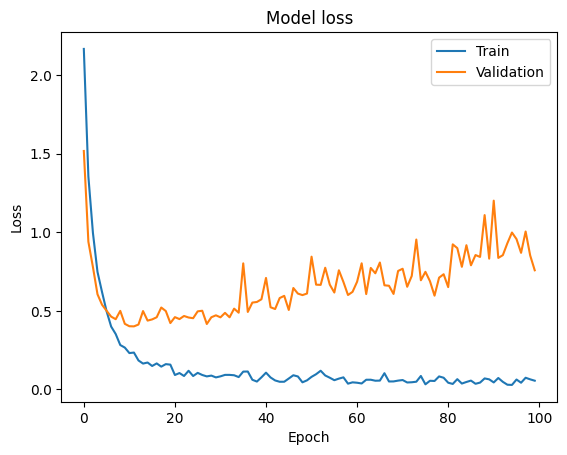

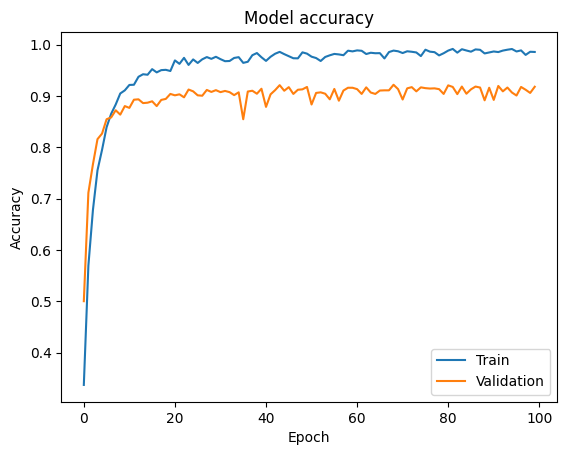

In [17]:
# Plot the performance of the model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

### Interpretation: 
1. At the beginning of training, the model quickly learns to generalize well to the validation data. The higher validation accuracy suggests that the model is capturing meaningful patterns in the data and not overfitting.
2. Transition stage (after epoch 20):
    After a certain point (around epoch 20), the model starts to show signs of overfitting. Overfitting occurs when the model becomes too specialized in the training data and doesn't generalize well to unseen data. The fluctuations in both accuracies indicate that the model is adjusting its weights to fit the training data more precisely, but this may not necessarily lead to improved performance on the validation set.
    The model is still learning and making progress, but the fluctuations suggest that it might be struggling to generalize perfectly to the validation data. The increasing gap between the training and validation accuracies indicates that the model's performance on unseen data (validation set) is not improving as quickly as its performance on the training data. 

# Prediction and displaying a subset of results

81/81 [==============================] - 0s 2ms/step


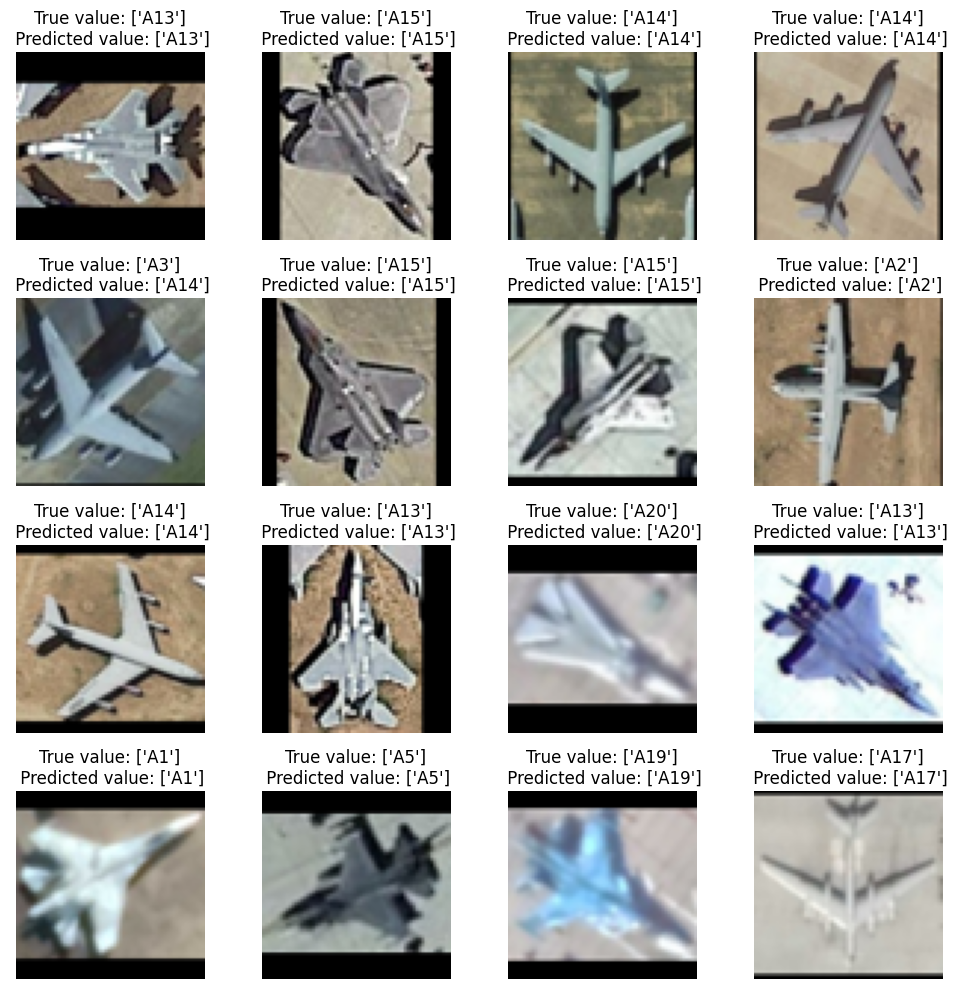

In [18]:
# Pridict
predictions = model.predict(X_test)

# Create a new instance of OneHotEncoder
encoder = OneHotEncoder()

# Fit the encoder on the original categorical labels
encoder.fit(orig_labels)

# Perform the inverse transformation using the OneHotEncoder
y_orig_true = encoder.inverse_transform(y_test)
y_orig_pred = encoder.inverse_transform(predictions)

# Display 16 predictions

# Set up the subplots
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
axs = axs.ravel()

# Generate some random indices
random_numbers = []
for _ in range(16):
    random_number = random.randint(0, X_test.shape[0])
    random_numbers.append(random_number)
    
for i, rand in enumerate(random_numbers):
    axs[i].imshow(X_test[rand], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f"True value: {y_orig_true[rand]}\n Predicted value: {y_orig_pred[rand]}")

plt.tight_layout()
plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 20.4 MB/s eta 0:00:00a 0:00:01


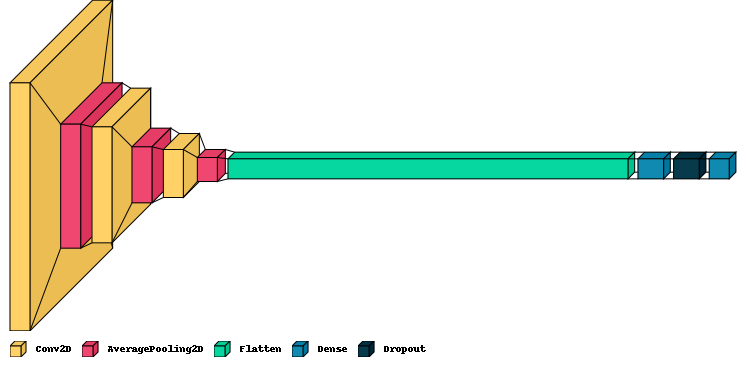

In [19]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model, legend=True)